# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
#%%pycodestyle
class MyKmeans:

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', n_local_trials=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.n_local_trials = n_local_trials

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Флаг, значение которого равно
        # новые_центроиды == старым(центроидам определенным на прошлом шаге)
        eq_flag = False

        # Инициализируем начальное значение центроидов
        if (self.init == 'random'):
            self.init_random_centroids(X, self.n_local_trials)
        elif (self.init == 'k-means++'):
            self.init_kmeans_pp_centroids(X, self.n_local_trials)
        else:
            raise ValueError('unknown init method')

        # Осуществляем цикл пока:
        #   1 - не достигнем max_iter
        #   2 - пока не перестанут изменяться центроиды( eq_flag == True)
        for it in range(self.max_iter):

            # Отнести каждый объект к ближайшему центру
            y = self.euclidean_distance(self.centroids, X)
            self.labels = np.argmin(y, axis=0)
            # Вычислить новое положение центров
            eq_flag = self.update_centroids(X)

            # Проверка: изменились ли центроиды
            if (eq_flag):
                break

        return self

    def init_random_centroids(self, X, n_local_trials):
        # Рандомно выбираем несколько(n_local_trials) раз
        # из них берем лучший вариант
        if n_local_trials is None:
            n_local_trials = 2 + int(np.log(self.k))
        seeds = np.random.permutation(X.shape[0])[:self.k]
        best_candidate = X[seeds]
        best_dist_sq = self.euclidean_distance(best_candidate, X)
        best_pot = best_dist_sq.sum()
        for trial in range(1, n_local_trials):
            seeds = np.random.permutation(X.shape[0])[:self.k]
            new_centroids = X[seeds]
            new_dist_sq = self.euclidean_distance(new_centroids, X)
            new_pot = new_dist_sq.sum()
            if (new_pot < best_pot):
                best_candidate = new_centroids
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        self.centroids = best_candidate
        current_pot = best_pot
        closest_dist_sq = best_dist_sq

    def init_kmeans_pp_centroids(self, X, n_local_trials):
        n_samples, n_features = X.shape
        n_clusters = self.k
        if n_local_trials is None:
            n_local_trials = 2 + int(np.log(n_clusters))
        # Выбираем первый центр рандомно
        center_id = np.random.randint(n_samples)
        self.centroids[0] = X[center_id]

        closest_dist_sq = self.euclidean_distance(
            self.centroids[0, np.newaxis], X)
        current_pot = closest_dist_sq.sum()
        for c in range(1, n_clusters):
            # Выбираем кандидатов
            rand_vals = np.random.random_sample(n_local_trials) * current_pot
            candidate_ids = np.searchsorted(np.cumsum(closest_dist_sq),
                                            rand_vals)

            # Вычисление расстояние кандидатов до центра
            distance_to_candidates = self.euclidean_distance(X[candidate_ids],
                                                             X)
            # Выбор лучшего кандидата
            best_candidate = None
            best_pot = None
            best_dist_sq = None
            for trial in range(n_local_trials):
                new_dist_sq = np.minimum(closest_dist_sq,
                                         distance_to_candidates[trial])
                new_pot = new_dist_sq.sum()

                if (best_candidate is None) or (new_pot < best_pot):
                    best_candidate = candidate_ids[trial]
                    best_pot = new_pot
                    best_dist_sq = new_dist_sq

            self.centroids[c] = X[best_candidate]
            current_pot = best_pot
            closest_dist_sq = best_dist_sq

    def update_centroids(self, X):
        new_centroids = np.copy(self.centroids)
        for j in range(self.k):
            X_tmp = X[[self.labels == j]]
            if (X_tmp.size != 0):
                new_centroids[j] = np.mean(X_tmp, axis=0)

        if ((self.centroids == new_centroids).all()):
            return True
        else:
            self.centroids = new_centroids
            return False

    @staticmethod
    def euclidean_distance(X, Y):
        x_dist = (X ** 2).sum(axis=1)
        y_dist = (Y ** 2).sum(axis=1)
        xy_dist = X.dot(Y.T)
        ans = - 2 * xy_dist + y_dist + x_dist.reshape(-1, 1)
        return ans

    def predict(self, X, y=None):
        y = self.euclidean_distance(self.centroids, X)
        labels = np.argmin(y, axis=0)
        return labels


class MyMiniBatchKMeans(MyKmeans):

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=100,
                 reassignment_ratio=0.01, n_local_trials=None):
        super().__init__(k, metric, max_iter, random_state, init,
                         n_local_trials)
        self.batch_size = batch_size
        self.reassignment_ratio = reassignment_ratio

    def fit(self, X):
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0]).astype(int)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        if (self.init == 'random'):
            self.init_random_centroids(X, self.n_local_trials)
        elif (self.init == 'k-means++'):
            self.init_kmeans_pp_centroids(X, self.n_local_trials)
        else:
            raise ValueError('unknown init method')
        centroids = np.ones((self.k, X.shape[1]))

        # https://algorithmicthoughts.wordpress.com/2013/07/26/machine-learning-mini-batch-k-means/
        v = np.zeros(self.k)

        for iteration in range(self.max_iter):
            seeds = np.random.permutation(X.shape[0])[:self.batch_size]
            M = X[seeds]
            distances = self.euclidean_distance(self.centroids, M)
            self.labels[seeds] = np.argmin(distances, axis=0)
            old_centroids = np.copy(self.centroids)
            for i, x in enumerate(M):
                index = self.labels[seeds[i]].astype(int)
                v[index] += 1
                eta = 1 / v[index]
                self.centroids[index] = (1 - eta) * self.centroids[
                    index] + eta * x
            if np.linalg.norm(
                    old_centroids - self.centroids) < self.reassignment_ratio:
                break

        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

In [5]:
X.shape

(100, 2)

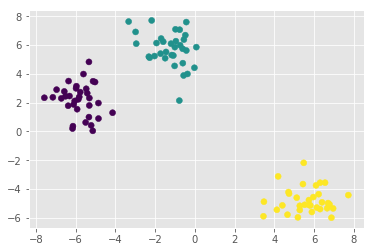

In [6]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [7]:
def benchmark(algorithm, X):
    kmeans = algorithm.fit(X)
    labels = algorithm.predict(X)
    return kmeans, labels  

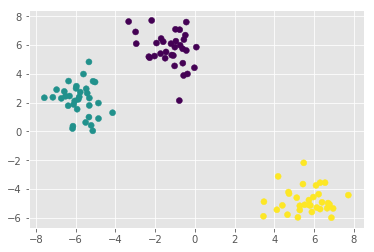

In [8]:
## Работоспособность MyKmeans
kmeans, labels = benchmark(MyKmeans(k=3, init='random'), X)
plt.scatter(X[:,0], X[:,1], c=labels)

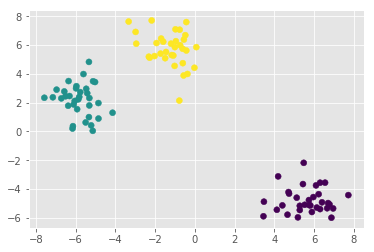

In [9]:
## Работоспособность MyKmeans++
kmeans, labels = benchmark(MyKmeans(k=3, init='k-means++'), X)
plt.scatter(X[:,0], X[:,1], c=labels)

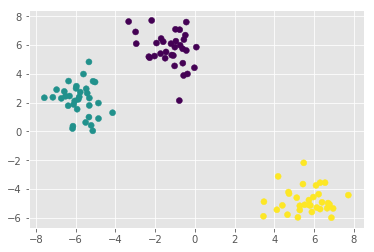

In [10]:
## Работоспособность MyKmeans с MiniBatchMyKmeans

kmeans, labels = benchmark(MyMiniBatchKMeans(k=3, init='random', batch_size=10), X)
plt.scatter(X[:,0], X[:,1], c=labels)

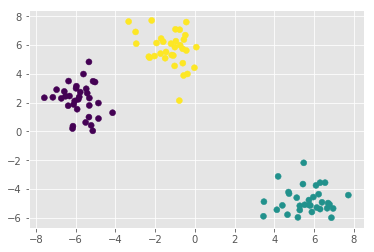

In [11]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans

kmeans, labels = benchmark(MyMiniBatchKMeans(k=3, init='k-means++', batch_size=10), X)
plt.scatter(X[:,0], X[:,1], c=labels)

In [12]:
## Время выполнения алгоритма Kmeans из sklearn init='random'

%timeit benchmark(KMeans(n_clusters=3, init='random', max_iter=1000), X)

20 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
## Время выполнения алгоритма Kmeans из sklearn init='k-means++'

%timeit benchmark(KMeans(n_clusters=3, init='k-means++', max_iter=1000), X)

24.7 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
## Время выполнения алгоритма MiniBatchKMeans из sklearn init='random'

%timeit benchmark(MiniBatchKMeans(n_clusters=3, init='random', max_iter=1000, batch_size=10), X)

27.4 ms ± 5.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
## Время выполнения алгоритма MiniBatchKMeans из sklearn init='k-means++'

%timeit benchmark(MiniBatchKMeans(n_clusters=3, init='k-means++', max_iter=1000, batch_size=10), X)

29.7 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
## Время выполнения алгоритма MyKmeans

%timeit benchmark(MyKmeans(k=3, init='random'), X)

1.03 ms ± 91.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
## Время выполнения алгоритма MyKmeans++
%timeit benchmark(MyKmeans(k=3, init='k-means++'), X)

791 µs ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
%timeit benchmark(MyMiniBatchKMeans(k=3, init='random', batch_size=10), X)

14.3 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
%timeit benchmark(MyMiniBatchKMeans(k=3, init='k-means++', batch_size=10), X)

15.7 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


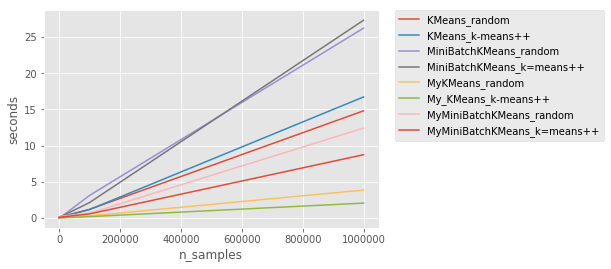

In [21]:
from timeit import timeit

centers = 3
n = [10 ** i for i in range(2, 7)]
algorithms_labels = ['KMeans_random',
                     'KMeans_k-means++',
                     'MiniBatchKMeans_random',
                     'MiniBatchKMeans_k=means++',
                     'MyKMeans_random',
                     'My_KMeans_k-means++',
                     'MyMiniBatchKMeans_random',
                     'MyMiniBatchKMeans_k=means++']
algorithm_time = [[0] * len(n) for i in range(len(algs))]
algorithms = [KMeans(n_clusters=centers, max_iter=1000),
              KMeans(n_clusters=centers, init='k-means++', max_iter=1000),
              MiniBatchKMeans(n_clusters=centers, max_iter=1000),
              MiniBatchKMeans(n_clusters=centers, init='k-means++',
                              max_iter=1000),
              MyKmeans(k=centers),
              MyKmeans(k=centers, init='k-means++'),
              MyMiniBatchKMeans(k=centers),
              MyMiniBatchKMeans(k=centers, init='k-means++')]

for i, n_samples in enumerate(n):
    X, y = make_blobs(n_samples=n_samples, n_features=2, centers=centers,
                      cluster_std=1,
                      center_box=(-20.0, 20.0), shuffle=False,
                      random_state=1234)
    for j, algorithm in enumerate(algorithms):
        algorithm_time[j][i] = timeit(lambda: benchmark(algorithm, X),
                                      number=3)

for i, label in enumerate(algorithms_labels):
    plt.plot(n, algorithm_time[i], label=label)

plt.xlabel('n_samples')
plt.ylabel('seconds')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [22]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [23]:
X = df_sns.iloc[:, 4:].values
X = (X - X.mean(axis=0))/X.std(axis=0)

In [24]:
def resault(labels):
    df_sns.loc[:, 'label'] = labels
    for c, group in df_sns.groupby('label'):
        print('Cluster: {}'.format(c))
        print('Size: {}'.format(len(group)))
        print(group.iloc[:, 4:-1].mean().nlargest(5))
        print('=' * 10 + '\n')
    

In [25]:
## MyKMeans

%time kmeans, labels = benchmark(MyKmeans(k=9, init='random'), X)
resault(labels)

CPU times: user 2.15 s, sys: 47.1 ms, total: 2.2 s
Wall time: 1.28 s
Cluster: 0
Size: 730
band        4.136986
marching    1.445205
music       1.230137
god         0.531507
dance       0.439726
dtype: float64

Cluster: 1
Size: 841
hollister      1.514863
abercrombie    1.172414
shopping       0.929845
music          0.916766
hair           0.908442
dtype: float64

Cluster: 2
Size: 18503
music       0.540129
god         0.314868
dance       0.213047
hair        0.185754
shopping    0.171702
dtype: float64

Cluster: 3
Size: 675
soccer      4.955556
music       0.774815
shopping    0.494815
god         0.454815
hair        0.432593
dtype: float64

Cluster: 4
Size: 504
god       3.918651
jesus     1.652778
church    1.468254
bible     1.111111
music     0.974206
dtype: float64

Cluster: 5
Size: 1959
swimming    1.447167
music       0.806534
shopping    0.520163
god         0.438999
hair        0.375191
dtype: float64

Cluster: 6
Size: 3782
dance       1.355103
music       1.126917
cute   

In [26]:
## MyKMeans++

%time kmeans, labels = benchmark(MyKmeans(k=9, init='k-means++'), X)
resault(labels)

CPU times: user 1.86 s, sys: 32.1 ms, total: 1.89 s
Wall time: 1.04 s
Cluster: 0
Size: 1097
dance    3.008204
dress    1.530538
music    0.989061
hair     0.842297
cute     0.724704
dtype: float64

Cluster: 1
Size: 846
hollister      1.508274
abercrombie    1.169031
shopping       0.921986
music          0.895981
hair           0.868794
dtype: float64

Cluster: 2
Size: 19535
music       0.529153
god         0.271001
dance       0.228411
hair        0.181572
shopping    0.170873
dtype: float64

Cluster: 3
Size: 4280
god         1.180607
music       1.159112
shopping    0.939953
church      0.850000
cute        0.847196
dtype: float64

Cluster: 4
Size: 2378
basketball    1.422204
football      1.126997
softball      1.071068
volleyball    0.832212
music         0.791001
dtype: float64

Cluster: 5
Size: 582
band        4.912371
marching    1.565292
music       1.364261
god         0.549828
dance       0.469072
dtype: float64

Cluster: 6
Size: 585
hair      3.723077
sex       3.403419
musi

In [27]:
## MyKMeans с MiniBatchMyKMeans

%time kmeans, labels = benchmark(MyMiniBatchKMeans(k=9, batch_size= 10), X)
resault(labels)

CPU times: user 417 ms, sys: 4.11 ms, total: 421 ms
Wall time: 256 ms
Cluster: 0
Size: 18
hair         5.333333
clothes      4.611111
music        4.444444
hollister    3.500000
sex          2.444444
dtype: float64

Cluster: 1
Size: 542
softball      4.492620
basketball    0.854244
music         0.843173
god           0.522140
shopping      0.494465
dtype: float64

Cluster: 2
Size: 236
god       5.775424
jesus     3.135593
church    2.796610
bible     1.279661
music     1.118644
dtype: float64

Cluster: 3
Size: 2080
hair     2.470673
music    1.947596
sex      1.479808
dance    1.297115
cute     1.157212
dtype: float64

Cluster: 4
Size: 418
dress       2.751196
dance       0.997608
music       0.921053
shopping    0.791866
hair        0.789474
dtype: float64

Cluster: 5
Size: 3335
shopping        1.509145
music           0.875562
dance           0.756222
god             0.520840
cheerleading    0.515742
dtype: float64

Cluster: 6
Size: 788
hollister      1.522843
abercrombie    1.17132

In [28]:
## MyKMeans++ с MiniBatchMyKMeans
%time kmeans, labels = benchmark(MyMiniBatchKMeans(k=9, init='k-means++', batch_size=10), X)
resault(labels)

CPU times: user 448 ms, sys: 8.27 ms, total: 456 ms
Wall time: 259 ms
Cluster: 0
Size: 740
hollister      1.481081
abercrombie    1.306757
shopping       0.920270
hair           0.875676
music          0.850000
dtype: float64

Cluster: 1
Size: 25743
music       0.621140
god         0.389504
dance       0.348483
shopping    0.298256
cute        0.259177
dtype: float64

Cluster: 2
Size: 49
cute          5.367347
volleyball    2.959184
hair          2.836735
sexy          2.428571
rock          2.326531
dtype: float64

Cluster: 3
Size: 244
tennis      4.557377
music       0.803279
god         0.651639
band        0.471311
shopping    0.467213
dtype: float64

Cluster: 4
Size: 1
blonde    327.0
sex        22.0
hair       12.0
god        10.0
die         6.0
dtype: float64

Cluster: 5
Size: 365
band        5.709589
marching    2.002740
music       1.504110
god         0.550685
dance       0.504110
dtype: float64

Cluster: 6
Size: 2144
hair     2.308302
music    1.896455
sex      1.414646
god

In [29]:
## Вывод

# Делая вывод, можно сказать, что нет лучшей реализации,
# все зависит от того, что больше в преоритете: качество/время.
# На графике кажется, что минибатч работаете медленнее и мой и стандартный,
# но это легко объясняется - необходимо грамотно выбирать параметры для минибатча: размер батча, точность
# Наилучшую точность, показывает инициализация k-means++, 
# но на более менее серьёзных данных сразу заметно различие во времени работы по равнению с random инициализацией
# Только благодаря k-means++ у меня получилось выделить из данных данный кластер:
# Cluster: 8
# Size: 1
# blonde    327.0
# sex        22.0
# hair       12.0
# god        10.0
# die         6.0
# Явно необычный случай в данных, который с помощью minibatch обнаружить не удалось
# Поэтому думаю для быстрой оценки больших данных можно пользоваться minibatch,
# но для более тонкой работы с данными запускать обычный Kmeans